In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from gensim.models import Word2Vec, KeyedVectors
import re
from gensim.downloader import load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from transformers import BertTokenizer, BertModel
import torch

In [2]:
df = pd.read_csv("data.csv")
df.head()

,Text,Label
0,Budget to set scene for election\r\n \r\n Gord...,0
1,Army chiefs in regiments decision\r\n \r\n Mil...,0
2,Howard denies split over ID cards\r\n \r\n Mic...,0
3,Observers to monitor UK election\r\n \r\n Mini...,0
4,Kilroy names election seat target\r\n \r\n Ex-...,0


In [3]:
df.tail()

,Text,Label
2220,India opens skies to competition\r\n \r\n Indi...,4
2221,Yukos bankruptcy 'not US matter'\r\n \r\n Russ...,4
2222,Survey confirms property slowdown\r\n \r\n Gov...,4
2223,High fuel prices hit BA's profits\r\n \r\n Bri...,4
2224,US trade gap hits record in 2004\r\n \r\n The ...,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB


In [5]:
df.describe()

,Label
count,2225.000000
mean,2.027416
std,1.438694
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [6]:
df.shape

(2225, 2)

In [7]:
df.isna().sum()

Text     0
Label    0
dtype: int64

In [8]:
df.nunique()

Text     2127
Label       5
dtype: int64

In [9]:
df.Label.value_counts()

Label
1    511
4    510
0    417
2    401
3    386
Name: count, dtype: int64

In [10]:
df.duplicated().sum()

98

In [11]:
df.drop_duplicates(keep='last', inplace=True)

In [12]:
df.duplicated().sum()

0

Text: It contains different categories of text data
Label: It contains labels for five different categories : 0,1,2,3,4


Politics = 0
Sport = 1
Technology = 2
Entertainment =3
Business = 4

In [13]:
df.replace({0:"Politics", 1:"Sport", 2:"Technology", 3:"Entertainment", 4:"Business"}, inplace=True)
df.Label.value_counts()

Label
Sport            505
Business         503
Politics         403
Entertainment    369
Technology       347
Name: count, dtype: int64

In [14]:
df.dtypes

Text     object
Label    object
dtype: object

In [15]:
label = df.Label.value_counts()
transuction = label.index
quantity = label.values

# draw pie circule with plotly
figure = px.pie(df,
               values = quantity,
               names = transuction,
               hole = .5,
               title = 'Label distribution of the Text')
figure.show()

C:\Users\Fulchany NANITH\AppData\Local\Temp\ipykernel_6948\4099696495.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




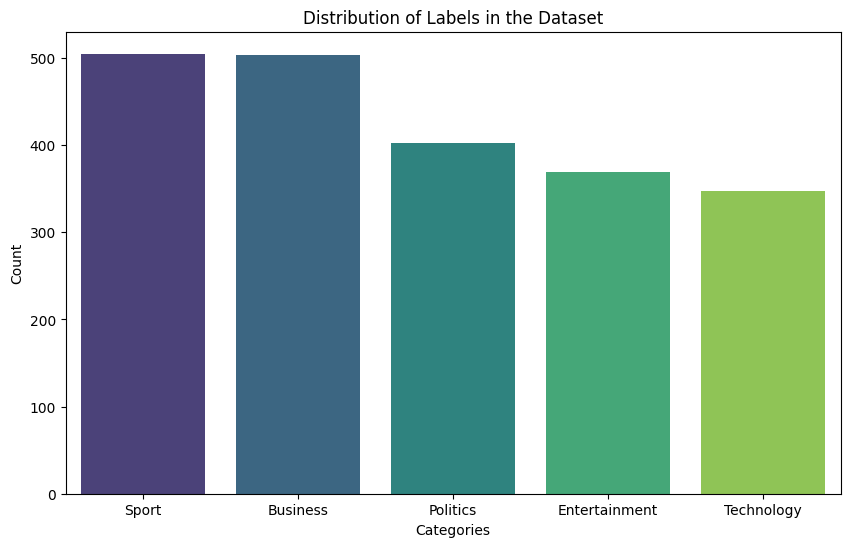

In [16]:
# Bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df, order=df['Label'].value_counts().index, palette='viridis')
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

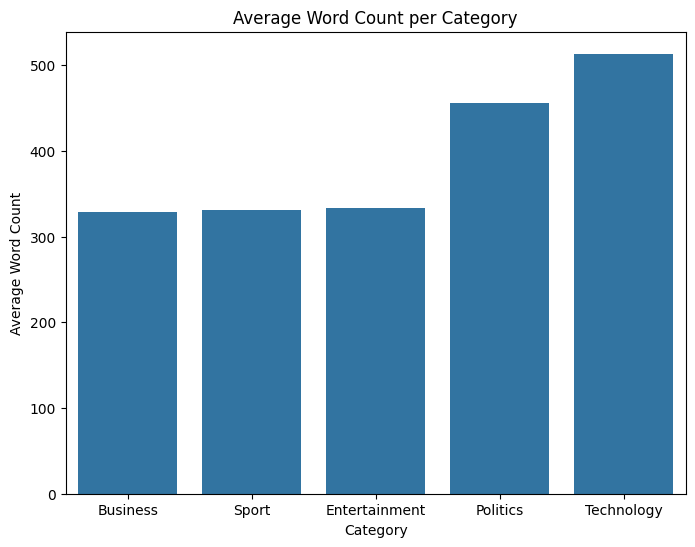

In [17]:
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

avg_word_count = df.groupby('Label')['word_count'].mean().sort_values()

plt.figure(figsize=(8,6))
sns.barplot(x=avg_word_count.index, y=avg_word_count.values)
plt.title('Average Word Count per Category')
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.show()

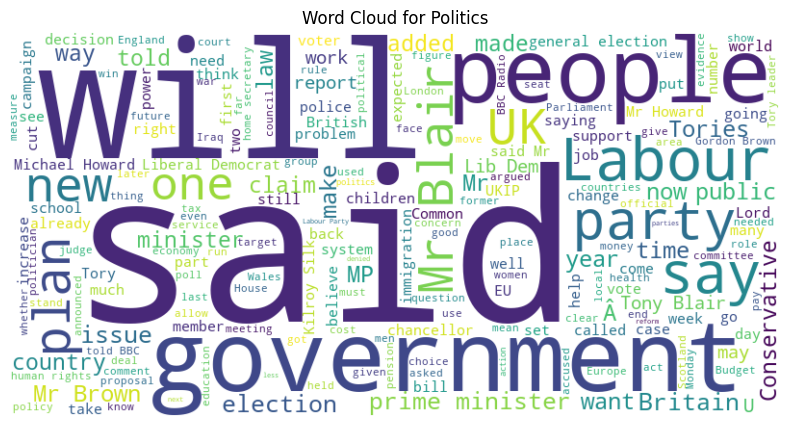

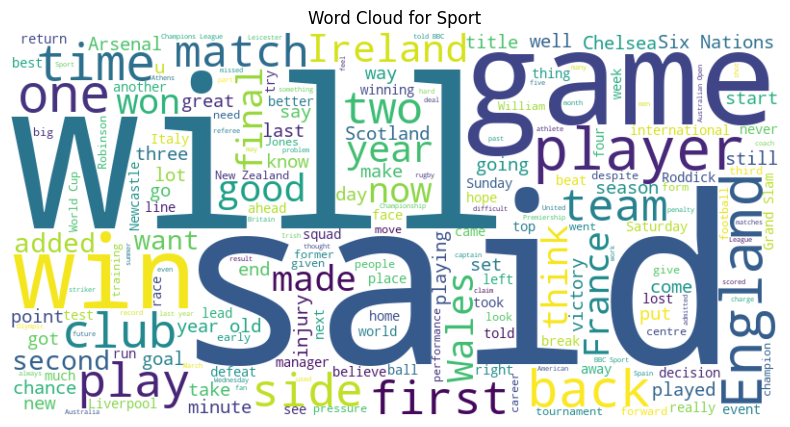

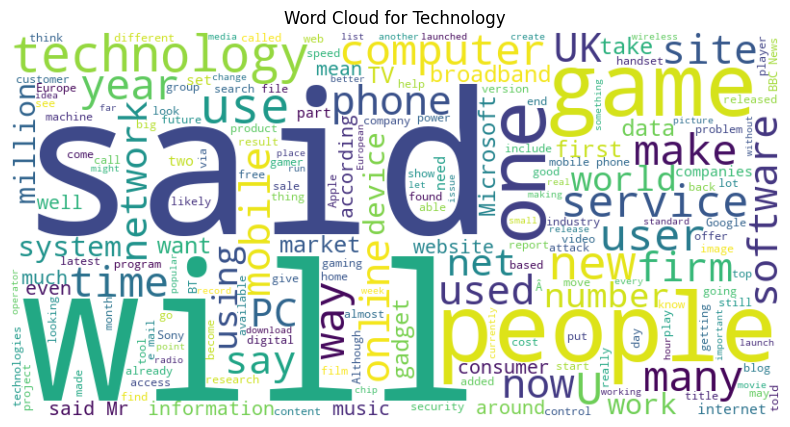

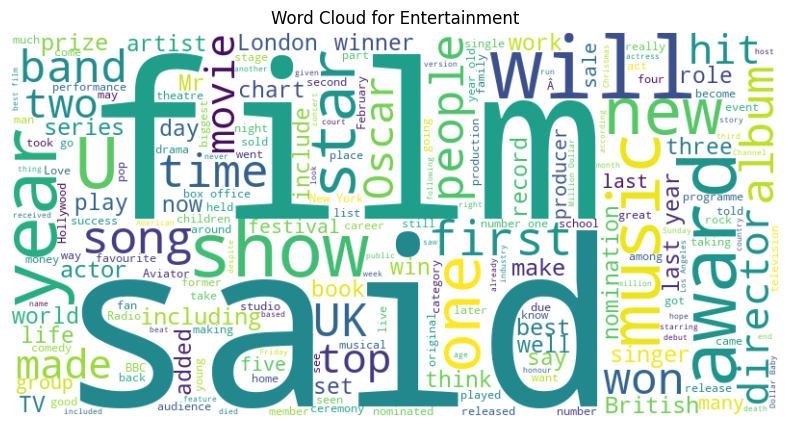

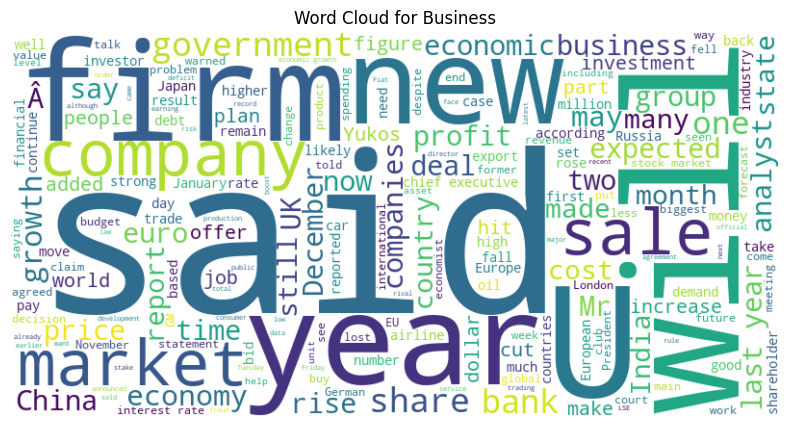

In [18]:
from wordcloud import WordCloud

categories = df['Label'].unique()

for category in categories:
    subset = df[df['Label'] == category]
    text = " ".join(subset['Text'].values)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
    plt.show()

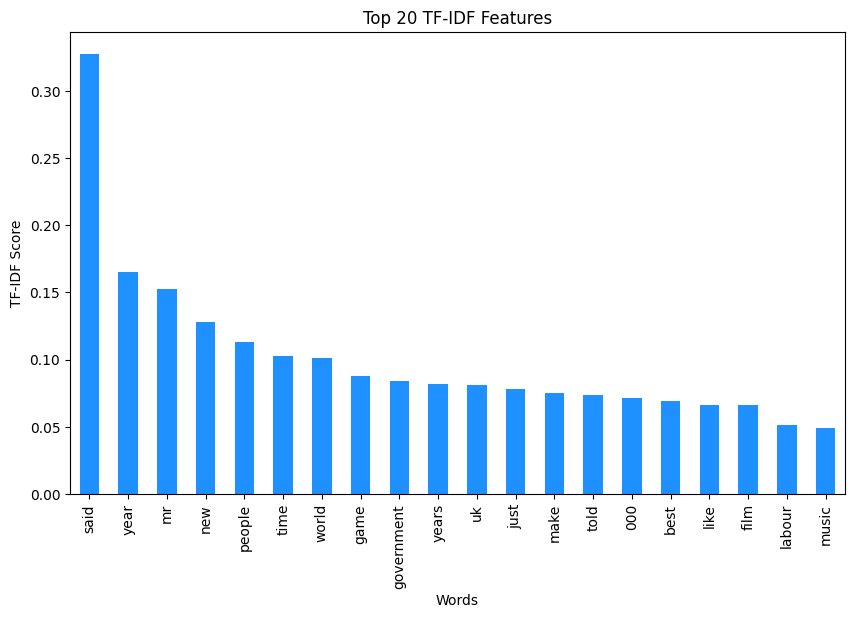

In [19]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = vectorizer.fit_transform(df['Text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Bar plot of top 20 words
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
tfidf_mean.plot(kind='bar', color='dodgerblue')
plt.title('Top 20 TF-IDF Features')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.show()

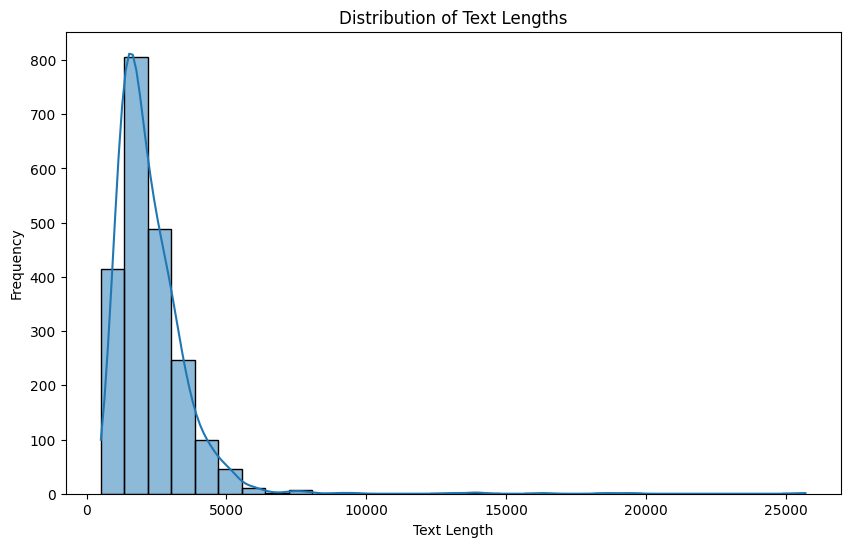

In [20]:
df['text_length'] = df['Text'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], kde=True, bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

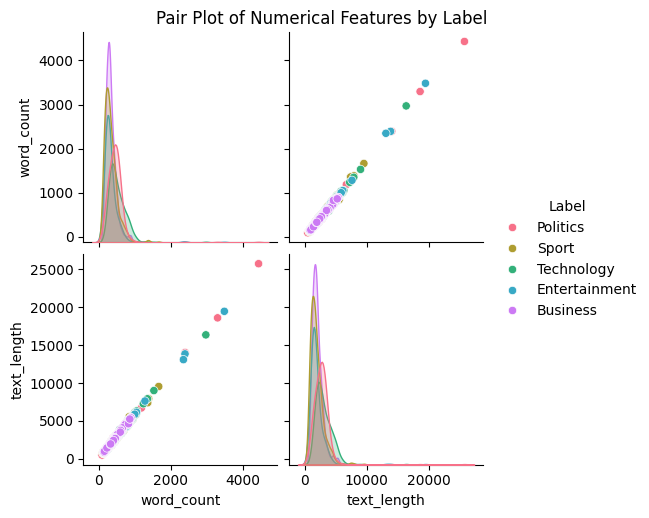

In [21]:
sns.pairplot(df, hue='Label', palette='husl')
plt.suptitle('Pair Plot of Numerical Features by Label', y=1.02)
plt.show()

C:\Users\Fulchany NANITH\AppData\Local\Temp\ipykernel_6948\2346593256.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




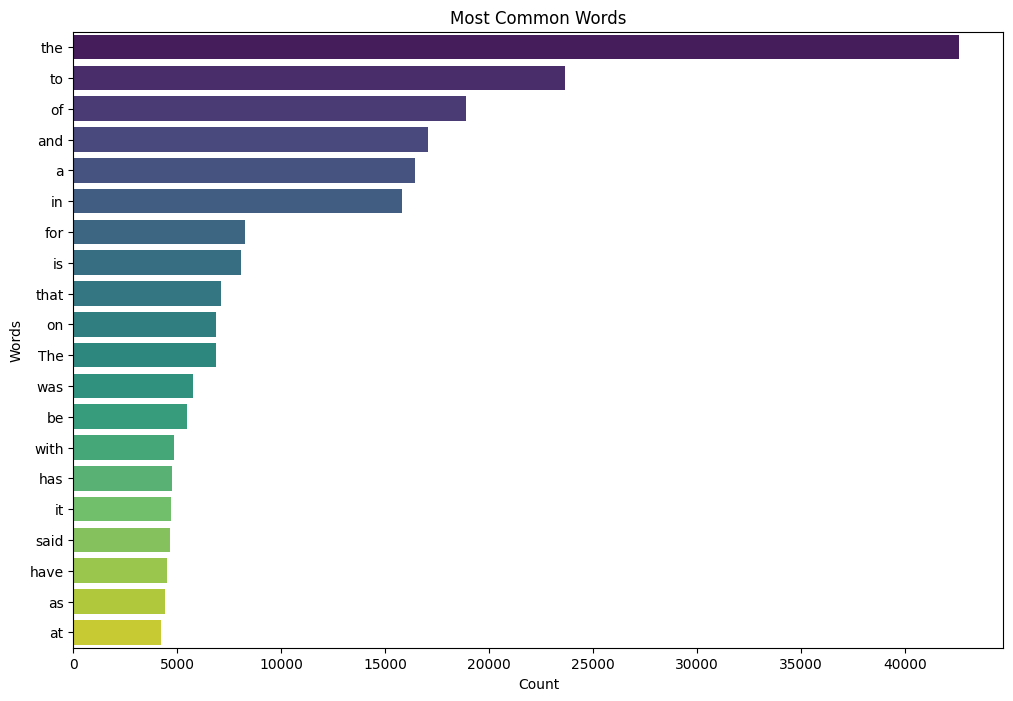

In [22]:
# Get all words from the 'Text' column and count their frequency
all_words = " ".join(df['Text']).split()
word_freq = Counter(all_words)

# Get the 20 most common words and their counts
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Create a DataFrame for the barplot
word_freq_df = pd.DataFrame({'Word': words, 'Count': counts})

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=word_freq_df, palette='viridis')
plt.title('Most Common Words')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

In [23]:
sport_texts = df[df['Label'] == 'Sport']['Text'].iloc[0]
print(sport_texts)

Hodges announces rugby retirement
 
 Scarlets and USA Eagles forward Dave Hodges has ended his playing career to pursue a coaching role in the States.
 
 The 36-year-old, who has 54 caps, was Llanelli's player of the season in 2001/2, but has battled injury for the last two of his seven years at Stradey. He tore a pectoral muscle against the Ospreys on Boxing Day, an injury that would have kept him out for the season. "Realising I would be unable to play this season, the club and I agreed to end my contract early," said Hodges.
 
 "It allows me to move back to the US and pursue opportunities there and allows the Scarlets to look to the next generation." The Scarlets have begun to rebuild their squad for next season after a disappointing Heineken Cup campaign, with plenty more signings and departures expected in the coming weeks.
 
 Scarlets chief executive Stuart Gallacher confirmed that 17 of the current squad would be out of contract in the summer. "We have a deliberate policy whereb

In [24]:
def cleanText(text):
    
    # Convert all letters to lower case
    txt = text.lower()
    # Remove mentions (e.g., @usernames)
    txt = re.sub(r"@\w+", "", txt)
    # Remove URLs (http, https, and www)
    txt = re.sub(r"http\S+|www\S+", "", txt)
    # Remove non-alphanumeric characters except for spaces
    txt = re.sub(r"[^a-z0-9\s]", "", txt)
    # Remove extra whitespace
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

In [25]:
cleantext = []

for item in df['Text']:
    txt = cleanText(item)
    cleantext += [txt]

df['clean_text'] = cleantext
df.head()

,Text,Label,word_count,text_length,clean_text
0,Budget to set scene for election\r\n \r\n Gord...,Politics,538,3163,budget to set scene for election gordon brown ...
1,Army chiefs in regiments decision\r\n \r\n Mil...,Politics,500,3035,army chiefs in regiments decision military chi...
3,Observers to monitor UK election\r\n \r\n Mini...,Politics,496,3107,observers to monitor uk election ministers wil...
4,Kilroy names election seat target\r\n \r\n Ex-...,Politics,440,2625,kilroy names election seat target exchat show ...
5,Donor attacks Blair-Brown 'feud'\r\n \r\n The ...,Politics,462,2805,donor attacks blairbrown feud the reported feu...


In [26]:
df = df.drop(columns=['Text', 'text_length', 'word_count'])
df = df.rename(columns={'clean_text': 'Text'})
df.tail()

,Label,Text
2220,Business,india opens skies to competition india will al...
2221,Business,yukos bankruptcy not us matter russian authori...
2222,Business,survey confirms property slowdown government f...
2223,Business,high fuel prices hit bas profits british airwa...
2224,Business,us trade gap hits record in 2004 the gap betwe...


In [27]:
X = df['Text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Train Word2Vec model
sentences = [text.split() for text in df['Text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)

# Function to convert text to average Word2Vec vector
def text_to_word2vec(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

In [29]:
# Convert texts to Word2Vec vectors
X_train_w2v = np.array([text_to_word2vec(text) for text in X_train])
X_test_w2v = np.array([text_to_word2vec(text) for text in X_test])

In [30]:
model_w2v = LogisticRegression()
model_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = model_w2v.predict(X_test_w2v)

In [31]:
print("Word2Vec Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_w2v))
print("Precision:", precision_score(y_test, y_pred_w2v, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_w2v, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_w2v, average='weighted'))

Word2Vec Model Performance:
Accuracy: 0.8685446009389671
Precision: 0.8695040089438415
Recall: 0.8685446009389671
F1 Score: 0.8678170616903966


In [31]:
# Load pre-trained GloVe model
glove_model = load('glove-wiki-gigaword-100')

# Function to convert text to GloVe vector
def text_to_glove(text):
    words = text.split()
    vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(glove_model.vector_size)

In [32]:
# Convert texts to GloVe vectors
X_train_glove = np.array([text_to_glove(text) for text in X_train])
X_test_glove = np.array([text_to_glove(text) for text in X_test])

In [33]:
# Train and evaluate Logistic Regression model
model_glove = LogisticRegression()
model_glove.fit(X_train_glove, y_train)
y_pred_glove = model_glove.predict(X_test_glove)

print("GloVe Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_glove))
print("Precision:", precision_score(y_test, y_pred_glove, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_glove, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_glove, average='weighted'))

GloVe Model Performance:
Accuracy: 0.9577464788732394
Precision: 0.958743818845275
Recall: 0.9577464788732394
F1 Score: 0.9579760541586786


c:\Users\Fulchany NANITH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

